In [1]:
from tensorflow.keras.applications.xception import Xception
import numpy as np
import pandas as pd
from matplotlib import ticker
#import seaborn as sn
import PIL
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
base = Xception(weights="imagenet",
               input_shape=(500, 825, 3),
               include_top=False,
               pooling="max")

x = base.output
#x = layers.Dropout(0.75)(x)
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = layers.Dense(16, activation='selu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
predictions = layers.Dense(16, activation='softmax')(x)#, kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005))(x)

model = Model(inputs=base.input, outputs=predictions)

# this is the model we will train

for layer in base.layers:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=["categorical_accuracy","top_k_categorical_accuracy"])

W1023 12:57:30.490440 140153842865984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1023 12:57:36.090098 140153842865984 nn_ops.py:4248] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [4]:
traingen = image.ImageDataGenerator(rescale=1./255)#,rotation_range=10,width_shift_range=20,height_shift_range=10,shear_range=10,horizontal_flip=True,vertical_flip=True)
validationgen = image.ImageDataGenerator(rescale=1./255)
testgen = image.ImageDataGenerator(rescale=1./255)

train = traingen.flow_from_directory("train",target_size=(500, 825), batch_size=110, shuffle=True)
val = validationgen.flow_from_directory("validation",target_size=(500, 825), batch_size=32, shuffle=False)
test=testgen.flow_from_directory("test",target_size=(500, 825), batch_size=32, shuffle=False)

Found 2049 images belonging to 16 classes.
Found 684 images belonging to 16 classes.
Found 683 images belonging to 16 classes.


In [36]:
call_list = [tf.keras.callbacks.ModelCheckpoint(
                 filepath='XAdamDrop{epoch:02d}-{val_categorical_accuracy:.4f}-{categorical_accuracy:.4f}.h5',
                 monitor='val_categorical_accuracy',
                 save_best_only=False,),
             
             tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.01,patience=4,),
             tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy',min_delta=0.005,patience=6,),
             tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',min_delta=0.005,patience=8,),
             
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_delta=0.05,),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',factor=0.5,patience=4,min_delta=0.005,)
            ]


more = model.fit_generator(train,
                        callbacks=call_list,
                              steps_per_epoch=np.ceil(2049/110),
                              epochs=50,
                              verbose=2,
                              validation_data= val,
                              validation_steps=np.ceil(684/32)
                              )

Epoch 1/50
19/19 - 39s - loss: 2.2177 - categorical_accuracy: 0.4451 - top_k_categorical_accuracy: 0.8346 - val_loss: 1.9823 - val_categorical_accuracy: 0.4313 - val_top_k_categorical_accuracy: 0.7851
Epoch 2/50
19/19 - 38s - loss: 2.1825 - categorical_accuracy: 0.4402 - top_k_categorical_accuracy: 0.8365 - val_loss: 1.9890 - val_categorical_accuracy: 0.4269 - val_top_k_categorical_accuracy: 0.7880
Epoch 3/50
19/19 - 37s - loss: 2.1752 - categorical_accuracy: 0.4597 - top_k_categorical_accuracy: 0.8321 - val_loss: 1.9643 - val_categorical_accuracy: 0.4327 - val_top_k_categorical_accuracy: 0.7851
Epoch 4/50
19/19 - 38s - loss: 2.2073 - categorical_accuracy: 0.4436 - top_k_categorical_accuracy: 0.8507 - val_loss: 1.9730 - val_categorical_accuracy: 0.4313 - val_top_k_categorical_accuracy: 0.7851
Epoch 5/50
19/19 - 38s - loss: 2.1795 - categorical_accuracy: 0.4612 - top_k_categorical_accuracy: 0.8228 - val_loss: 1.9728 - val_categorical_accuracy: 0.4327 - val_top_k_categorical_accuracy: 0.

In [ ]:
def smooth(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

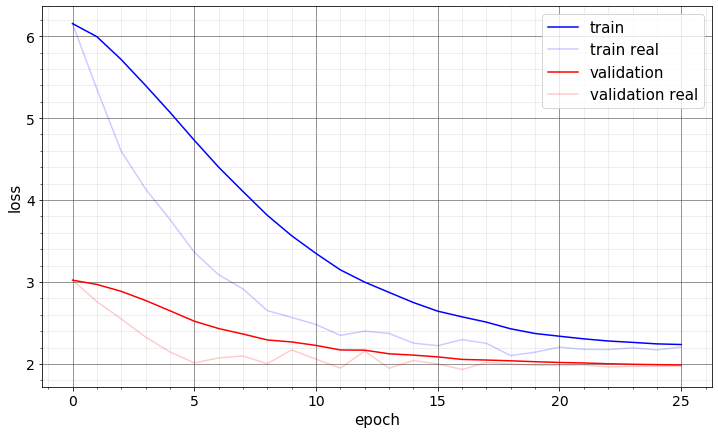

In [40]:
fig,ax=plt.subplots(figsize=(12,7))
ax.tick_params(labelsize=14)
plt.plot(smooth(history.history['loss']+more.history['loss']),color="Blue")
plt.plot(history.history['loss']+more.history['loss'],alpha=0.2,color="Blue")
plt.plot(smooth(history.history['val_loss']+more.history['val_loss']),color="Red")
plt.plot(history.history['val_loss']+more.history['val_loss'],alpha=0.2,color="Red")
plt.ylabel('loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.grid(b=True, which='major', color='#444444', linestyle='-',alpha=0.7)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#plt.yscale("log")
plt.legend(['train', 'train real','validation', 'validation real'], loc='upper right',fontsize=15)
plt.show()

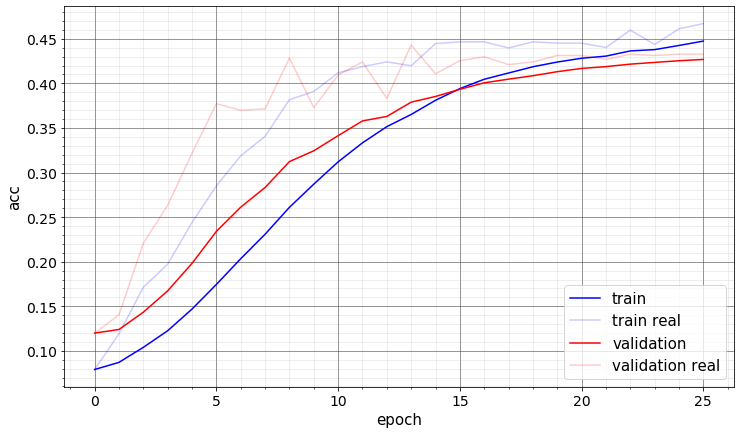

In [41]:
fig,ax=plt.subplots(figsize=(12,7))
ax.tick_params(labelsize=14)
plt.plot(smooth(history.history['categorical_accuracy']+more.history['categorical_accuracy']),color="Blue")
plt.plot(history.history['categorical_accuracy']+more.history['categorical_accuracy'],alpha=0.2,color="Blue")
plt.plot(smooth(history.history['val_categorical_accuracy']+more.history['val_categorical_accuracy']),color="Red")
plt.plot(history.history['val_categorical_accuracy']+more.history['val_categorical_accuracy'],alpha=0.2,color="Red")
plt.ylabel('acc',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.grid(b=True, which='major', color='#444444', linestyle='-',alpha=0.7)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#plt.yscale("log")
plt.legend(['train','train real', 'validation', 'validation real'], loc='lower right',fontsize=15)
plt.show()

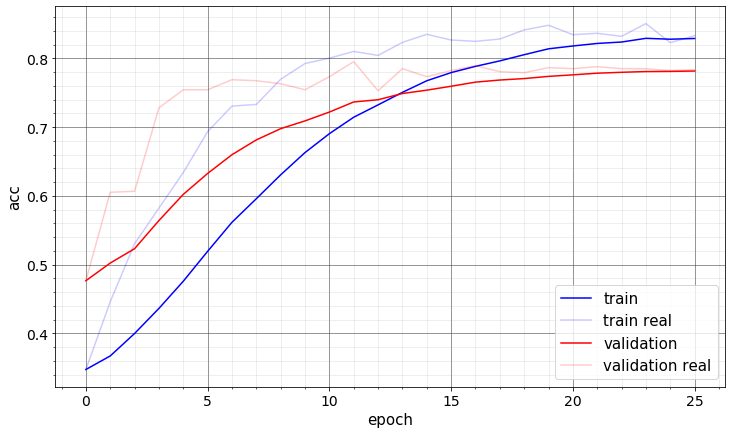

In [42]:
fig,ax=plt.subplots(figsize=(12,7))
ax.tick_params(labelsize=14)
plt.plot(smooth(history.history['top_k_categorical_accuracy']+more.history['top_k_categorical_accuracy']),color="Blue")
plt.plot(history.history['top_k_categorical_accuracy']+more.history['top_k_categorical_accuracy'],alpha=0.2,color="Blue")
plt.plot(smooth(history.history['val_top_k_categorical_accuracy']+more.history['val_top_k_categorical_accuracy']),color="Red")
plt.plot(history.history['val_top_k_categorical_accuracy']+more.history['val_top_k_categorical_accuracy'],alpha=0.2,color="Red")
plt.ylabel('acc',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.grid(b=True, which='major', color='#444444', linestyle='-',alpha=0.7)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#plt.yscale("log")
plt.legend(['train','train real', 'validation', 'validation real'], loc='lower right',fontsize=15)
plt.show()

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 825, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 249, 412, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 249, 412, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 249, 412, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

#
#
#
# Fine-tuning

In [ ]:
Y_pred = model.predict_generator(val,steps=np.ceil(684/32))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(val.classes, y_pred)
plt.figure(figsize=(15,11))
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm, annot=True,annot_kws={"size": 16},fmt="d")# font size

print('Classification Report')
print(classification_report(val.classes, y_pred,target_names=val.class_indices))

Found 2049 images belonging to 16 classes.
Classification Report
               precision    recall  f1-score   support

           3d       0.63      0.52      0.57       137
     barChart       0.32      0.53      0.40       114
     box&line       0.91      0.15      0.26       130
    dashboard       0.45      0.55      0.50       131
  distibution       0.65      0.27      0.38       122
      heatmap       0.49      0.63      0.55       158
    lineChart       0.60      0.04      0.08        72
          map       0.83      0.15      0.25       133
       matrix       0.27      0.80      0.40       129
      medical       0.81      0.71      0.76       132
      network       0.69      0.69      0.69       132
parallelCoord       0.74      0.82      0.78       131
      picture       0.90      0.27      0.42       133
  scatterPlot       0.49      0.37      0.42       132
        table       0.40      0.97      0.56       131
        words       0.84      0.29      0.43       132

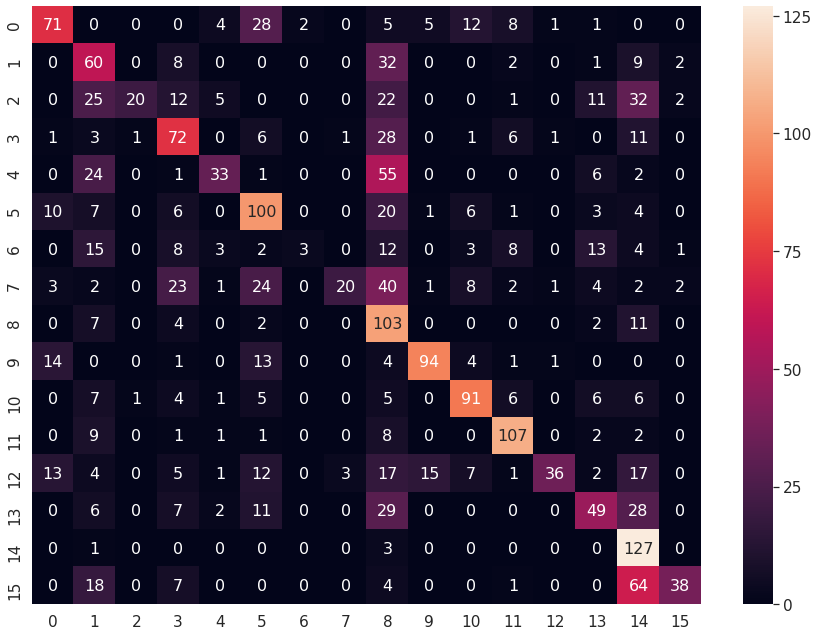

In [19]:
t = image.ImageDataGenerator(rescale=1./255)
tr= t.flow_from_directory("train",target_size=(500, 825), batch_size=32, shuffle=False)

ref48=load_model("m19-0.4826.hdf5")
Y_pred48 = ref48.predict_generator(tr,steps=np.ceil(2049/32))
y_pred48 = np.argmax(Y_pred48, axis=1)

cm48=confusion_matrix(tr.classes, y_pred48)

plt.figure(figsize=(15,11))
sn.set(font_scale=1.4)#for label size
sn.heatmap(cm48, annot=True,annot_kws={"size": 16},fmt="d")# font size

print('Classification Report')
print(classification_report(tr.classes, y_pred48,target_names=tr.class_indices))

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)


In [ ]:
ref=load_model("m46.h5")

for layer in ref.layers[:131]:
   layer.trainable = False
for layer in ref.layers[131:]:
   layer.trainable = True

In [ ]:
call_list = [tf.keras.callbacks.EarlyStopping(
                monitor='categorical_accuracy',
                patience=1,)
             ,tf.keras.callbacks.ModelCheckpoint(
                 filepath='tune{epoch:02d}-{val_categorical_accuracy:.4f}-{categorical_accuracy:.4f}.h5',
                 monitor='val_categorical_accuracy',
                 save_best_only=True,)
             ,tf.keras.callbacks.ReduceLROnPlateau(
                 monitor='val_loss',
                 factor=0.2,
                 patience=3,)
            ]


ref.compile(optimizer=optimizers.RMSprop(), 
              loss='categorical_crossentropy', 
              metrics=["categorical_accuracy","top_k_categorical_accuracy"])

historytune = model.fit_generator(train,
                        callbacks=call_list,
                              steps_per_epoch=np.ceil(2049/32),
                              epochs=30,
                              verbose=2,
                              validation_data= val,
                              validation_steps=np.ceil(684/32)
                              )
#history = ref.fit_generator(train,callbacks=call_list,steps_per_epoch=np.ceil(2049/32),epochs=30,verbose=2, validation_steps=np.ceil(684/32))